In [1]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from neurocorgi_sdk import NeuroCorgiNet
from neurocorgi_sdk.transforms import ToNeuroCorgiChip

In [2]:
# If possible, set up the GPU 0 for the application
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       ToNeuroCorgiChip()
                                       ])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      ToNeuroCorgiChip()
                                      ])

dataset_train = datasets.CIFAR100(root="./data", train=True, download=True, transform=train_transforms)
dataset_test = datasets.CIFAR100(root="./data", train=False, download=True, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=False, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image / 255
    image = image.transpose(1, 2, 0)
    image = image.clip(0, 1)
    return image

In [5]:
classes = train_loader.dataset.classes
print(classes)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

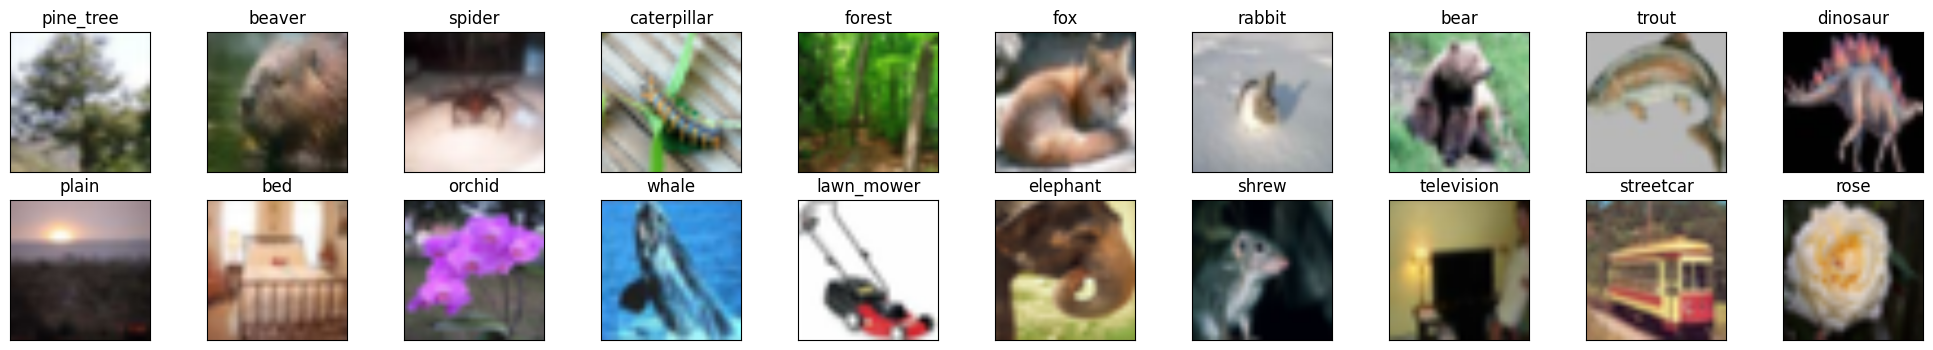

In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [7]:
# For this example, we use the model pretrained and quantized with the ImageNet dataset
extractor = NeuroCorgiNet("neurocorginet_imagenet.safetensors")
extractor.to(device)

NeuroCorgiNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (scale1): Scaling_FixedPoint()
  (conv1_3x3_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
  (relu1_3x3_dw): ReLU(inplace=True)
  (scale1_3x3_dw): Scaling_FixedPoint()
  (conv1_1x1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (relu1_1x1): ReLU(inplace=True)
  (scale1_1x1): Scaling_FixedPoint()
  (conv2_3x3_dw): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64)
  (relu2_3x3_dw): ReLU(inplace=True)
  (scale2_3x3_dw): Scaling_FixedPoint()
  (conv2_1x1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (relu2_1x1): ReLU(inplace=True)
  (scale2_1x1): Scaling_FixedPoint()
  (conv3_3x3_dw): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
  (relu3_3x3_dw): ReLU(inplace=True)
  (scale3_3x3_dw): Scaling_FixedPoint()
  (conv3_1x1): Conv2d(128, 128, kernel_size=(1, 1), st

In [8]:
# Classification head for Cifar100
head = torch.nn.Sequential(
    torch.nn.AvgPool2d(7, stride=7),
    torch.nn.Flatten(start_dim=1),
    torch.nn.Linear(1024, 100))
head.to(device)
head = head.train()

In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(head.parameters(), lr=0.01)

In [10]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    print('epoch :', (e+1))
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
  
    for i, (inputs, labels) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        div4, div8, div16, div32 = extractor(inputs)
        outputs = head(div32)

        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            for i, (val_inputs, val_labels) in enumerate(tqdm(test_loader)):
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)

                div4, div8, div16, div32 = extractor(val_inputs)
                val_outputs = head(div32)

                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
        
        epoch_loss = running_loss/len(train_loader.dataset)
        epoch_acc = running_corrects.float()/ len(train_loader.dataset)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        
        val_epoch_loss = val_running_loss/len(test_loader.dataset)
        val_epoch_acc = val_running_corrects.float()/ len(test_loader.dataset)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)

        print(f'training loss: {epoch_loss:.4f}, acc: {epoch_acc.item():.4f} ')
        print(f'validation loss: {val_epoch_loss:.4f}, acc: {val_epoch_acc.item():.4f}\n')

epoch : 1


100%|██████████| 78/78 [00:15<00:00,  4.99it/s]


training loss: 0.0221, acc: 0.3692 
validation loss: 0.0158, acc: 0.5120

epoch : 2


100%|██████████| 78/78 [00:15<00:00,  5.03it/s]


training loss: 0.0139, acc: 0.5594 
validation loss: 0.0129, acc: 0.5731

epoch : 3


100%|██████████| 78/78 [00:15<00:00,  5.02it/s]


training loss: 0.0120, acc: 0.6010 
validation loss: 0.0118, acc: 0.5967

epoch : 4


100%|██████████| 78/78 [00:15<00:00,  5.00it/s]


training loss: 0.0110, acc: 0.6223 
validation loss: 0.0112, acc: 0.6092

epoch : 5


100%|██████████| 78/78 [00:15<00:00,  5.02it/s]


training loss: 0.0104, acc: 0.6383 
validation loss: 0.0107, acc: 0.6216

epoch : 6


100%|██████████| 78/78 [00:15<00:00,  5.03it/s]


training loss: 0.0099, acc: 0.6509 
validation loss: 0.0104, acc: 0.6285

epoch : 7


100%|██████████| 78/78 [00:15<00:00,  4.92it/s]


training loss: 0.0096, acc: 0.6604 
validation loss: 0.0102, acc: 0.6375

epoch : 8


100%|██████████| 78/78 [00:14<00:00,  5.35it/s]


training loss: 0.0093, acc: 0.6685 
validation loss: 0.0100, acc: 0.6376

epoch : 9


100%|██████████| 78/78 [00:15<00:00,  5.20it/s]


training loss: 0.0091, acc: 0.6743 
validation loss: 0.0099, acc: 0.6429

epoch : 10


100%|██████████| 78/78 [00:14<00:00,  5.35it/s]


training loss: 0.0089, acc: 0.6821 
validation loss: 0.0098, acc: 0.6487

epoch : 11


100%|██████████| 78/78 [00:14<00:00,  5.28it/s]


training loss: 0.0087, acc: 0.6888 
validation loss: 0.0097, acc: 0.6513

epoch : 12


100%|██████████| 78/78 [00:14<00:00,  5.29it/s]


training loss: 0.0085, acc: 0.6928 
validation loss: 0.0095, acc: 0.6544

epoch : 13


100%|██████████| 78/78 [00:14<00:00,  5.28it/s]


training loss: 0.0084, acc: 0.6976 
validation loss: 0.0094, acc: 0.6583

epoch : 14


100%|██████████| 78/78 [00:14<00:00,  5.24it/s]


training loss: 0.0082, acc: 0.7017 
validation loss: 0.0094, acc: 0.6583

epoch : 15


100%|██████████| 78/78 [00:14<00:00,  5.25it/s]

training loss: 0.0081, acc: 0.7053 
validation loss: 0.0093, acc: 0.6605



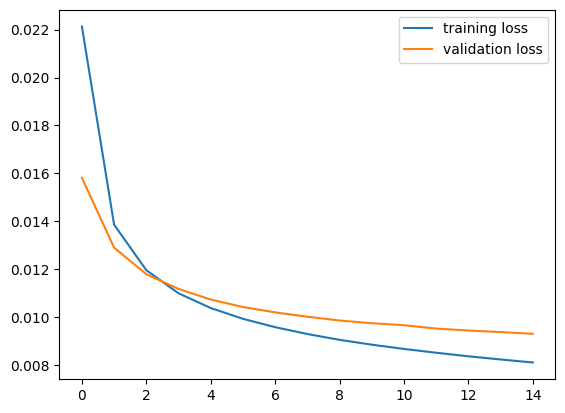

In [11]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

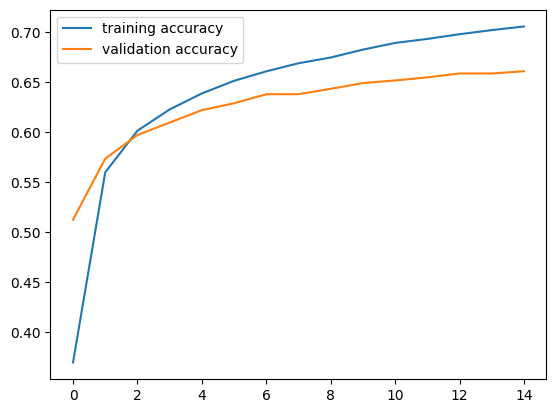

In [12]:
running_corrects_history = [x.to("cpu") for x in running_corrects_history]
val_running_corrects_history = [x.to("cpu") for x in val_running_corrects_history]

plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

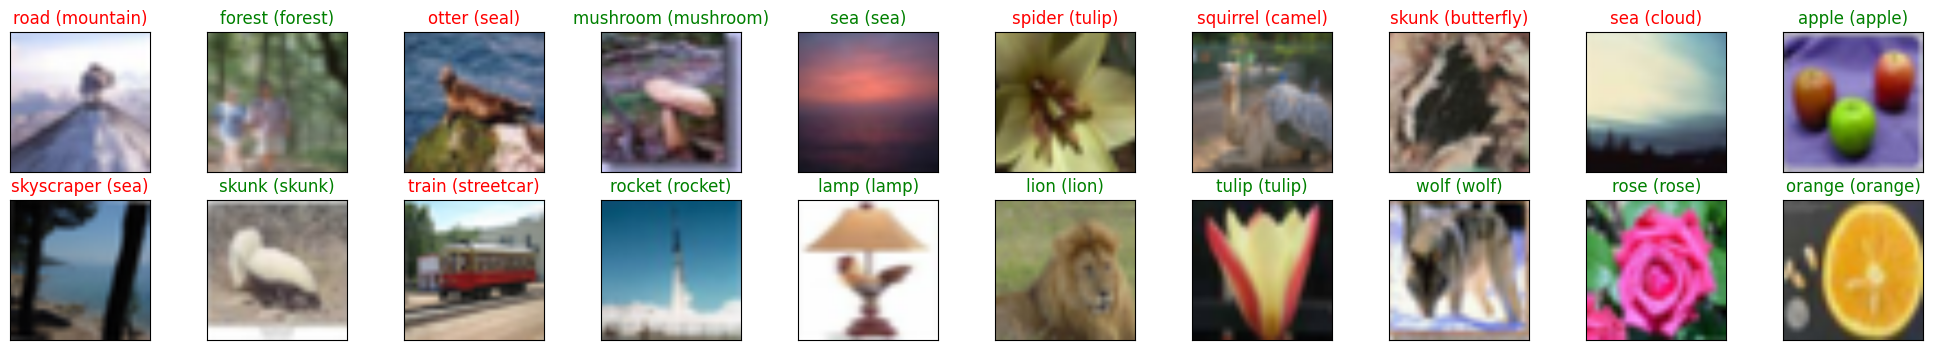

In [13]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

_, _, _, div32 = extractor(images)
output = head(div32)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), 
                                  str(classes[labels[idx].item()])), 
                                  color=("green" if preds[idx]==labels[idx] else "red"))